# Data science friday tales

### Lia Silva-Lopez

---

*Tuesday, 19/03/2019*

## This story starts with a reading accident

#### One moment you are reading a book...

<img src="img/reading_accident.png">

#### ...And then Fréchet hits you.

## Bounds for distributions* in terms of its marginals?

* That makes perfect sense!

* Why aren't Fréchet bounds for distributions more mainstream? 

* Is it because it's hard to pronounce?

*_with distributions we mean CDFs, not densities_

## Allright, let's point the fingers at ourselves:

---

## What would _I_ do with Fréchet bounds?

<img src="https://media.giphy.com/media/4uraUi810KSMo/giphy.gif">

## Idea 1: Use them to estimate Kernel Bandwidths

The *whole point* of bounds is to try not to break them.

##### Are we breaking Fréchet bounds when CDF estimations with Kernels?
###### And if we break them, how *badly* are we breaking those bounds? 
###### And what is the consequence of building estimates that break Fréchet bounds?

## Fréchet bounds + BW estimation in KDEs?

* The bounds can help prune the search space:
    * Removing parameters that build estimates outside the bounds.
    * Or (if the above was too violent), prune using thresholds. 

### Even bolder:
* Use the bounds stand-alone to construct likelihood functions and use them directly to fit the bandwidths.

### How does bandwidth selection look like?
Code for bandwith selection methods in StatsModels can be found [here](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/_kernel_base.html). 

As the library is today (march 2019), there is no obviously direct way to feed ranges of hyperparameters in order to constrain the bandwidth selection process. So, I made some simple modifications to be able to affect how the base methods to calculate a bandwidth are used. Those modifications are below.

<img src="https://data.whicdn.com/images/40743151/original.gif">

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst
import statsmodels.api as sm
from scipy import optimize

from statsmodels.nonparametric import kernels


kernel_func = dict(wangryzin=kernels.wang_ryzin,
                   aitchisonaitken=kernels.aitchison_aitken,
                   gaussian=kernels.gaussian,
                   aitchison_aitken_reg = kernels.aitchison_aitken_reg,
                   wangryzin_reg = kernels.wang_ryzin_reg,
                   gauss_convolution=kernels.gaussian_convolution,
                   wangryzin_convolution=kernels.wang_ryzin_convolution,
                   aitchisonaitken_convolution=kernels.aitchison_aitken_convolution,
                   gaussian_cdf=kernels.gaussian_cdf,
                   aitchisonaitken_cdf=kernels.aitchison_aitken_cdf,
                   wangryzin_cdf=kernels.wang_ryzin_cdf,
                   d_gaussian=kernels.d_gaussian)

def gpke(bwp, dataxx, data_predict, var_type, ckertype='gaussian',
         okertype='wangryzin', ukertype='aitchisonaitken', tosum=True):
    r"""Returns the non-normalized Generalized Product Kernel Estimator"""
    kertypes = dict(c=ckertype, o=okertype, u=ukertype)
    Kval = np.empty(dataxx.shape)
    for ii, vtype in enumerate(var_type):
        func = kernel_func[kertypes[vtype]]
        Kval[:, ii] = func(bwp[ii], dataxx[:, ii], data_predict[ii])

    iscontinuous = np.array([c == 'c' for c in var_type])
    dens = Kval.prod(axis=1) / np.prod(bwp[iscontinuous])
    #dens = np.nanprod(Kval,axis=1) / np.prod(bwp[iscontinuous])
    if tosum:
        return dens.sum(axis=0)
    else:
        return dens


class LeaveOneOut(object):
    def __init__(self, X):
        self.X = np.asarray(X)

    def __iter__(self):
        X = self.X
        nobs, k_vars = np.shape(X)

        for i in range(nobs):
            index = np.ones(nobs, dtype=np.bool)
            index[i] = False
            yield X[index, :]



def loo_likelihood(bww, datax, var_type, func=lambda x: x, ):
    #print(bww)
    LOO = LeaveOneOut(datax)
    L = 0
    for i, X_not_i in enumerate(LOO):
        f_i = gpke(bww, dataxx=-X_not_i, data_predict=-datax[i, :],
                   var_type=var_type)
        L += func(f_i)
    return -L


def get_bw(datapfft ,var_type ,reference):
    # Using leave-one-out likelihood
    # the initial value for the optimization is the normal_reference
    # h0 = normal_reference()

    data = adjust_shape(datapfft, len(var_type))

    h0 =reference
    fmin =lambda bb, funcx: loo_likelihood(bb, data, var_type, func=funcx)
    bw = optimize.fmin(fmin, x0=h0, args=(np.log, ),
                       maxiter=1e3, maxfun=1e3, disp=0, xtol=1e-3)
    # bw = self._set_bw_bounds(bw)  # bound bw if necessary
    return bw

def adjust_shape(dat, k_vars):
    """ Returns an array of shape (nobs, k_vars) for use with `gpke`."""
    dat = np.asarray(dat)
    if dat.ndim > 2:
        dat = np.squeeze(dat)
    if dat.ndim == 1 and k_vars > 1:  # one obs many vars
        nobs = 1
    elif dat.ndim == 1 and k_vars == 1:  # one obs one var
        nobs = len(dat)
    else:
        if np.shape(dat)[0] == k_vars and np.shape(dat)[1] != k_vars:
            dat = dat.T

        nobs = np.shape(dat)[0]  # ndim >1 so many obs many vars

    dat = np.reshape(dat, (nobs, k_vars))
    return dat

In [2]:
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


## Generate & visualize some data
Same parameters as the Fréchet notebook, all coming from a beta.

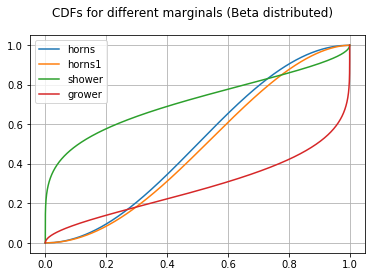

In [3]:
n=500
distr=spst.beta
smpl=np.linspace(0,1,num=n)
params={'horns':(0.5,0.5),
      'horns1':(0.5,0.55),
      'shower':(5.,2.),
      'grower':(2.,5.)}
v_type=f'{"c"*len(params)}'
#plot the cdfs
fig, ax = plt.subplots()
list(map(lambda x: ax.plot(distr.cdf(smpl,*x),smpl) , params.values()))
ax.legend(list(params.keys()))
fig.suptitle(f'CDFs for different marginals (Beta distributed)')
plt.grid()
plt.savefig('../cdfs_beta_different.png', dpi=100)
plt.show()

In [4]:
#Generate some independent data for each parameter set
mvdata={k:distr.rvs(*params[k],size=n) for k in params}

In [5]:
rd=np.array(list(mvdata.values()))

### Testing vanilla bandwidth estimation

In [6]:
%timeit -n2 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='normal_reference')
dens_u_rot = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='normal_reference')
print('bw with reference',dens_u_rot.bw, '(only available for gaussian kernels)')

2 loops, best of 3: 106 µs per loop
bw with reference [0.17402781 0.16777569 0.07661515 0.07925317] (only available for gaussian kernels)


In [7]:
%timeit -n1 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ml')
dens_u_ml = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ml')
print('bw with maximum likelihood',dens_u_ml.bw)

/home/lia/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_density.py:161: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


1 loop, best of 3: 24.7 s per loop
bw with maximum likelihood [0.03361851 0.07064256 0.10817853 0.11647636]


In [ ]:
# BW with least squares takes >8x more than with ml
#%timeit -n2 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ls')
#dens_u_ls = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ls')
#print('bw with least squares',dens_u_ls.bw)

### Getting BW from statsmodels puppet
We build a puppet out of statsmodels code. First we verify that we can get reasonable estimates of bandwidth. 

Then we add an option to allow Fréchet bounds to prune hyperparameter search.

In [8]:
#first try: attempt to piggyback on the methods in statsmodels to generate the bandwidth from a choice.
#see if we get close results from dens_u_ml
tst=get_bw(rd,v_type,np.round(dens_u_rot.bw,3))#dens_u_rot.bw)

/home/lia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log


In [ ]:
print('our estimate:',tst,'\nrule-of-thumb estimate:',dens_u_rot.bw,'\n ml estimate:',dens_u_ml.bw)

## Now let's check how the KP estimations fit on Fréchet's bounds

In [ ]:
def get_frechets(dvars):
    d=len(dvars)
    n=len(dvars[0])
    dimx=np.array(range(d))
    un=np.ones(d,dtype=int)
    bottom_frechet = np.array([max( np.sum( dvars[dimx,un*i] ) +1-d, 0 ) 
                               for i in range(n) ])
    top_frechet = np.array([min([y[i] for y in dvars]) for i in range(n)])
    return {'top': top_frechet, 'bottom': bottom_frechet}

In [9]:
def check_frechet_fails(guinea_cdf,frechets):
    fails={'top':[], 'bottom':[]}
    for n in range(len(guinea_cdf)):
        #n_hyper_point=np.array([x[n] for x in rd])
        if guinea_cdf[n]>frechets['top'][n]:
            fails['top'].append(True)
        else:
            fails['top'].append(False)

        if guinea_cdf[n]<frechets['bottom'][n]:
            fails['bottom'].append(True)
        else:
            fails['bottom'].append(False)
    return {'top':np.array(fails['top']),
            'bottom':np.array(fails['bottom'])}

In [ ]:
%timeit -n10 get_frechets(rd)
frechets=get_frechets(rd)

## Fréchet Bound Violations by all estimators

In [ ]:
guinea_pig=sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw=tst)
guinea_cdf=guinea_pig.cdf()
print(guinea_cdf.shape)

In [ ]:
guinea_fails=check_frechet_fails(guinea_cdf,frechets)
print('Frechet Violations:','top:', np.sum(guinea_fails['top']), ' bottom:',np.sum(guinea_fails['bottom']))

In [ ]:
vanilla_pig=sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw=dens_u_rot.bw)
vanilla_cdf=vanilla_pig.cdf()
print(vanilla_cdf.shape)

In [ ]:
vanilla_fails=check_frechet_fails(vanilla_cdf,frechets)
print('Frechet Violations:','top:', np.sum(vanilla_fails['top']), ' bottom:',np.sum(vanilla_fails['bottom']))

#### Misc

Testing LeaveOneOut class

In [ ]:
X = np.random.normal(0, 1, [10,2])
loo = LeaveOneOut(X)
for x in loo:
    print ('hihi',x)